# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [79]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import DataScienceHelperLibrary as dsh

from IPython.display import HTML
from IPython.display import display, clear_output
from importlib import reload

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Load dada and quick check

In [2]:
# load in the data
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

from sqlalchemy import create_engine

engine = create_engine('sqlite:///{}'.format('CustomerData.db'))

In [3]:
azdias = pd.read_sql_table('azdias', engine)
customers = pd.read_sql_table('customers', engine)

Let's have a quick look at the first top rows, analyze number of missing nan values in columns and plot it.

In [92]:
dsh.TailHead(azdias)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,3,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1
6,910248,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,4.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2
7,910261,-1,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1,1,1
8,645145,-1,9.0,16.0,NaN,NaN,NaN,NaN,16.0,2.0,...,4.0,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3
9,645153,-1,5.0,17.0,NaN,NaN,NaN,NaN,17.0,9.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3


In [93]:
dsh.AnalyzeDataTypes(azdias)

-------------------- Analysing fatatypes/s --------------------
int64 :  93
float64 :  267
object :  6
-------------------- Finished analysing datatypes --------------------


In [94]:
[x for x in azdias.columns if azdias[x].dtype == object]

['CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM',
 'OST_WEST_KZ']

In [95]:
dsh.AnalyzeNanColumns(azdias)

-------------------- Analysis of Columns with NaN values --------------------
Columns having all values: 93, 25.41%
LNR, type: int64                         0.0
AGER_TYP, type: int64                    0.0
D19_BANKEN_ANZ_12, type: int64           0.0
D19_BANKEN_ANZ_24, type: int64           0.0
D19_BANKEN_DATUM, type: int64            0.0
D19_BANKEN_DIREKT, type: int64           0.0
D19_BANKEN_GROSS, type: int64            0.0
D19_BANKEN_LOKAL, type: int64            0.0
D19_BANKEN_OFFLINE_DATUM, type: int64    0.0
D19_BANKEN_ONLINE_DATUM, type: int64     0.0
D19_BANKEN_REST, type: int64             0.0
D19_BEKLEIDUNG_GEH, type: int64          0.0
D19_BEKLEIDUNG_REST, type: int64         0.0
D19_BILDUNG, type: int64                 0.0
D19_BIO_OEKO, type: int64                0.0
D19_BUCH_CD, type: int64                 0.0
D19_DIGIT_SERV, type: int64              0.0
D19_DROGERIEARTIKEL, type: int64         0.0
D19_ENERGIE, type: int64                 0.0
D19_FREIZEIT, type: int64    

In [96]:
def PlotIsNullDist(df, top = 100, axis = 0, toplabels = 20, kind = 'bar'):
    '''
    Plot distribution of null values.
    
    INPUT:
    df: Dataframe
    top: when axis = 1, consider top sorted
    toplabels: print top sorted
    kind: chart
    
    OUTPUT:
    returns plotted dataframe
    '''
    
    dfPlt = None

    if axis == 0:
        dfPlt = df.isnull().sum(axis = axis).sort_values(ascending = False)[:top]
        dfPlt = dfPlt.apply(lambda x: (x * 100) / df.shape[0])
        ax = dfPlt.plot(kind = kind)
    else:
        vc = df.isnull().sum(axis = axis).value_counts()
        dfPlt = pd.DataFrame(data=vc.values, index = vc.index)
        ax = dfPlt.plot(kind = kind)
        _ = ax.set_title('Value count overview')
        _ = ax.set_ylabel('Number of rows...')
        _ = ax.set_xlabel('... having # nan values')
    _ = ax.set_xticklabels([])
    print(dfPlt[:toplabels])
    
    return dfPlt

          0
5    190567
6    161599
4    119198
16    85645
15    66641
7     51469
253   45578
252   27921
3     19718
8     12873
2      6988
17     5056
225    5015
9      4945
69     4589
18     4533
226    4393
14     4306
72     3892
70     3707


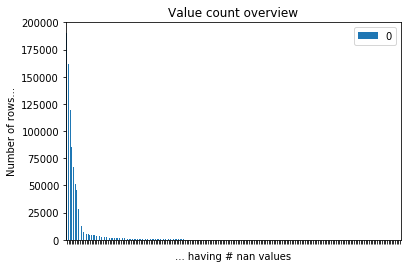

In [97]:
_ = PlotIsNullDist(azdias, axis = 1)

There are 190567 rows with only 5 nan values, 161599 rows with 6 nan values, 45578 rows with 253 nan values and so on.

ALTER_KIND4                    99.864792
ALTER_KIND3                    99.307691
ALTER_KIND2                    96.690047
ALTER_KIND1                    90.904837
EXTSEL992                      73.399639
KK_KUNDENTYP                   65.596749
ALTERSKATEGORIE_FEIN           29.504130
D19_LETZTER_KAUF_BRANCHE       28.849522
D19_LOTTO                      28.849522
D19_VERSI_ONLINE_QUOTE_12      28.849522
D19_BANKEN_ONLINE_QUOTE_12     28.849522
D19_SOZIALES                   28.849522
D19_GESAMT_ONLINE_QUOTE_12     28.849522
D19_KONSUMTYP                  28.849522
D19_TELKO_ONLINE_QUOTE_12      28.849522
D19_VERSAND_ONLINE_QUOTE_12    28.849522
KBA05_MOTOR                    14.959701
KBA05_MOD8                     14.959701
KBA05_MOD4                     14.959701
KBA05_MOD3                     14.959701
dtype: float64


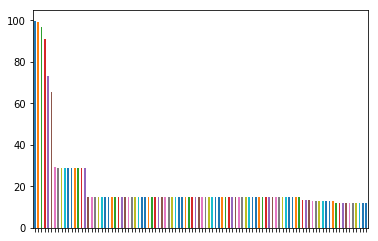

In [98]:
_ = PlotIsNullDist(azdias)

The analysis shows that there are columns:

- Columns having > 50% and <= 70% missing values: 1, 0.27%
    - KK_KUNDENTYP, type: float64    0.655967

- Columns having > 70% missing values: 5, 1.37%
    - ALTER_KIND1, type: float64    0.909048
    - ALTER_KIND2, type: float64    0.966900
    - ALTER_KIND3, type: float64    0.993077
    - ALTER_KIND4, type: float64    0.998648
    - EXTSEL992, type: float64      0.733996

This large amount of missing values is not helpuf and I will be dropped in the main cleaning function below. 

Now I load the attribute files to get known/unknown values for each column and convert - if identifier for unknown values are given (mostly 0 or -1) - the corresponding values in the columns to nan.

Then I check again how many nan values are present in all columns and depending on that, I determine the limit when to drop columns.

For further "configurations" I store data in the following config class. The attributes are filled based on findings in azdias and used in the cleaning function.

### Read attribute files

In [99]:
class CleanConfig:
    
    def IsNone(inp):
        return dsh.IsNullOrEmpty(inp)
    
    # The objects are set/filled in the same order they are listed up 
    
    ColumnsToDrop = []  
    
    RowsToTropByMisNan = 0.0
    
    ColumnValues = {}
    
    ColumnsWithoutInfo = []
    
    AttributesNotInAzdias = []
    
    AttributeLevelsNotInAzdias  = []
    
    D19Columns = []
    D19Unique  = []
    
    ColumnsTypeToFloat = []
    
    ColumnsToOneHotEnc = []
    
    ColumnsReorderValues = []
    
    ColumnsSummarize = {}
    
    ColumnsBinaryEncode = []
    
    ColumnsOneHotEncode = []

In [100]:
def ReadAttributeFiles():
    xlAttributes = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
    xlInfos = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx')
    return xlAttributes, xlInfos

In [101]:
a, b = ReadAttributeFiles()

In [102]:
a.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly


In [103]:
b.head()

,Unnamed: 0,Information level,Attribute,Description,Additional notes
0,NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,NaN,ANREDE_KZ,gender,NaN
3,NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


The following class is a container for column name and - if given - identfier for unknown values (0, -1), known values or numerical values identified by "...".
These class elements are stored in CleanConfig.ColumnValues.

In [104]:
class ColumnValues:
    def __init__(self, columnName):
        self.ColumnName = columnName
        self.UnknownValues = []
        self.KnownValues = []
        self.AllValues = []
        self.MissingDesc = []
        self.Meanings = []
        self.LowestValue = None
        self.DType = None
        
    def Add(self, isunknown, value):
        if isunknown:
            self.UnknownValues.append(value)
        else:
            self.KnownValues.append(value)
        self.AllValues.append(value)
    
    def IsNumeric(self):
        return self.DType in dsh.NumberTypes

def LoadColumnsAndValuesInfos(df):
    '''
    Load excel files and initialize CleanConfig
    '''
    xlAttributes, xlInfos = ReadAttributeFiles()
    currentAttrib = ''
    CleanConfig.ColumnValues = {}
    CleanConfig.ColumnsWithoutInfo = []
    count = 0
    colVal = None
    lowestIdentify = ['no ', 'low', 'urban', 'demanding', 'lowest', 'marginal', 'minimal']
    # iterate over all rows
    
    for ind, row in xlAttributes.iterrows():
        
        # remember the current row
        if row['Attribute'] is not np.nan:
            currentAttrib = row['Attribute']
            
            if currentAttrib not in df.columns:
                CleanConfig.AttributesNotInAzdias.append(currentAttrib)
                colVal = None
                continue
            
            if colVal is not None:
                if not colVal.IsNumeric():
                    colVal.MissingDesc = set(df[colVal.ColumnName].unique()) - set(colVal.AllValues)
                CleanConfig.ColumnValues[colVal.ColumnName] = colVal
                
            colVal = ColumnValues(currentAttrib)
            colVal.DType = df[currentAttrib].dtype
        
        # When row is not contained in azdias
        if colVal is None:
            continue
        
        isunknown = 'unknown' in str(row['Meaning'])
        currentVal = row['Value']
        colVal.Meanings.append(row['Meaning'])
        
        # if value is a number, then add and continue
        # else try to split and parse to float
        # else add the original string value.
        try:
            if type(currentVal) in dsh.NumberTypes:

                colVal.Add(isunknown, str(currentVal))
                colVal.Add(isunknown, currentVal)
                flt = float(currentVal)
                colVal.Add(isunknown, str(flt))


                if not colVal.LowestValue is None:
                    continue
                if colVal.LowestValue is None and any(x in str(row['Meaning']) for x in lowestIdentify):
                    colVal.LowestValue = flt

                continue

            # skip numerical columns
            if '.' in currentVal:
                continue

            if ',' in currentVal:
                splt = currentVal.split(',')
                for val in splt:
                    try:
                        colVal.Add(isunknown, val.strip())
                        flt = float(val.strip())
                        colVal.Add(isunknown, flt)

                        if not colVal.LowestValue is None:
                            continue

                        if colVal.LowestValue is None and any(x in str(row['Meaning']) for x in lowestIdentify):
                            colVal.LowestValue = flt
                    except:
                        colVal.Add(isunknown, val)

       
        except:
            print('Error while processing row {} with value "{}"'.format(ind, currentVal))
    
    
    for col in df.columns:
        if not col in CleanConfig.ColumnValues.keys():
            colVal = ColumnValues(col)
            colVal.DType = df[col].dtype
            colVal.AllValues = list(df[col].unique())
            CleanConfig.ColumnsWithoutInfo.append(col)
            CleanConfig.ColumnValues[colVal.ColumnName] = colVal            
    
    for ind, row in xlInfos.iterrows():
        
        col = row['Attribute']
        if col is np.nan:
            continue
        
        for colsplt in col.split(' '):
            if len(colsplt) == 0:
                continue
                
            if colsplt in CleanConfig.ColumnValues.keys():
                continue
                
            if colsplt not in df.columns:
                CleanConfig.AttributeLevelsNotInAzdias.append(colsplt)
                continue

            cv = ColumnValues(colsplt)
            cv.DType = df[colsplt].dtype

            CleanConfig.ColumnValues[colsplt] = cv
    
    print('Columns and attributes successfully loaded')
    
    
    
LoadColumnsAndValuesInfos(azdias)

Columns and attributes successfully loaded


### Check categorical columns

In [105]:
for col in azdias.columns:
    if azdias[col].dtype == object:
        uqv = azdias[col].unique()
        if len(uqv) < 100:
            print(col, azdias[col].unique())
        else:
            print(col, ' > 100')

CAMEO_DEU_2015 [None '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A'
 '5D' '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C'
 '7C' '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B'
 '6F' '5F' '1C' 'XX']
CAMEO_DEUG_2015 [None '8.0' '4.0' '2.0' '6.0' '1.0' '9.0' '5.0' '7.0' '3.0' '4' '3' '7'
 '2' '8' '9' '6' '5' '1' 'X']
CAMEO_INTL_2015 [None '51.0' '24.0' '12.0' '43.0' '54.0' '22.0' '14.0' '13.0' '15.0'
 '33.0' '41.0' '34.0' '55.0' '25.0' '23.0' '31.0' '52.0' '35.0' '45.0'
 '44.0' '32.0' '22' '24' '41' '12' '54' '51' '44' '35' '23' '25' '14' '34'
 '52' '55' '31' '32' '15' '13' '43' '33' '45' 'XX']
D19_LETZTER_KAUF_BRANCHE [None 'D19_UNBEKANNT' 'D19_SCHUHE' 'D19_ENERGIE' 'D19_KOSMETIK'
 'D19_VOLLSORTIMENT' 'D19_SONSTIGE' 'D19_BANKEN_GROSS'
 'D19_DROGERIEARTIKEL' 'D19_HANDWERK' 'D19_BUCH_CD' 'D19_VERSICHERUNGEN'
 'D19_VERSAND_REST' 'D19_TELKO_REST' 'D19_BANKEN_DIREKT' 'D19_BANKEN_REST'
 'D19_FREIZEIT' 'D19_LEBENSMITTEL' 'D19_HAUS_DEKO' 'D19_B

CAMEO columns contain 'X', 'XX'. I add these values to the UnknownValues-list in config so that these values will be replaced with np.nan.

The column 'EINGEFUEGT_AM' will be excluded from analysis because I don't see any link between creation of data row and persons behaviour. 

In [106]:
CleanConfig.ColumnValues['CAMEO_DEU_2015'].UnknownValues.append('XX')
CleanConfig.ColumnValues['CAMEO_DEUG_2015'].UnknownValues.append('X')
CleanConfig.ColumnValues['CAMEO_INTL_2015'].UnknownValues.append('XX')

In [107]:
CleanConfig.ColumnsToDrop.append('EINGEFUEGT_AM')

In [108]:
'D19_LETZTER_KAUF_BRANCHE' in CleanConfig.ColumnsWithoutInfo

True

I wil have a closer look to the column 'D19_LETZTER_KAUF_BRANCHE' because there is no description:

In [109]:
CleanConfig.D19Columns = list(dsh.SelectColumnsByWildcard(azdias, 'D19*').columns)
CleanConfig.D19Unique = list(azdias['D19_LETZTER_KAUF_BRANCHE'].unique())

_ = [print(x, type(x)) for x in CleanConfig.D19Unique if x not in CleanConfig.D19Columns]

-------------------- Start finding and keeping columns matchting to wildcards: ['D19*'] --------------------
-------------------- Finished keeping columns matchting to wildcards: 68 --------------------
None <class 'NoneType'>
D19_UNBEKANNT <class 'str'>


So this column just references to contained those columns that are already in the dataframe (except "D19_UNBEKANNT" ("unbekannt" means "unknown").

I add both values (None, D19_UNBEKANNT') to the cleaning config.

In [110]:
CleanConfig.ColumnValues['D19_LETZTER_KAUF_BRANCHE'].UnknownValues = [
    x for x in CleanConfig.D19Unique if x not in CleanConfig.D19Columns
]

In [111]:
azdias[CleanConfig.ColumnsWithoutInfo].head()

,LNR,AKT_DAT_KL,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,...,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNLAGE,ZABEOTYP
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
1,910220,9.0,NaN,NaN,NaN,NaN,21.0,0.0,12.0,3.0,...,3.0,1.0,0.0,0.0,4.0,8.0,11.0,10.0,4.0,5
2,910225,9.0,NaN,NaN,NaN,NaN,17.0,0.0,7.0,3.0,...,5.0,0.0,1.0,0.0,2.0,9.0,9.0,6.0,2.0,5
3,910226,1.0,NaN,NaN,NaN,NaN,13.0,0.0,2.0,2.0,...,5.0,0.0,0.0,1.0,0.0,7.0,10.0,11.0,7.0,3
4,910241,1.0,NaN,NaN,NaN,NaN,14.0,0.0,3.0,4.0,...,3.0,0.0,1.0,0.0,2.0,3.0,5.0,4.0,3.0,4


Text(0,0.5,'# of missing values')

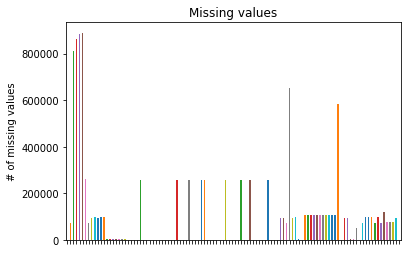

In [112]:
ax = azdias[CleanConfig.ColumnsWithoutInfo].isnull().sum().plot(kind = 'bar')
ax.set_xticklabels([])
ax.set_title('Missing values')
ax.set_ylabel('# of missing values')

In [113]:
sorted(CleanConfig.ColumnsWithoutInfo)

['AKT_DAT_KL',
 'ALTERSKATEGORIE_FEIN',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ANZ_KINDER',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ARBEIT',
 'BALLRAUM',
 'CAMEO_DEU_2015',
 'CAMEO_INTL_2015',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_KONSUMTYP',
 'D19_KONSUMTYP_MAX',
 'D19_KOSMETIK',
 'D19_LEBENSMITTEL',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_RATGEBER',
 'D19_REISEN',
 'D19_SAMMELARTIKEL',
 'D19_SCHUHE',
 'D19_SONSTIGE',
 'D19_SOZIALES',
 'D19_TECHNIK',
 'D

In [114]:
dsh.AnalyzeValueCounts(azdias[CleanConfig.ColumnsWithoutInfo])

-------------------- Dataframe value counts analye started --------------------
********************  ********************
More than 20 different values:  891221
Name:  LNR , dtype:  int64
********************  ********************
********************  ********************
1.0    390258
9.0    270663
5.0     29203
6.0     27655
3.0     24880
4.0     21466
7.0     21026
8.0     17485
2.0     15086
Name: AKT_DAT_KL, dtype: int64
********************  ********************
********************  ********************
18.0    6703
17.0    6394
8.0     6343
7.0     6249
16.0    6124
15.0    6008
14.0    5992
9.0     5846
13.0    5713
10.0    5678
12.0    5576
11.0    5506
6.0     4875
5.0     1501
4.0     1084
3.0     1063
2.0      403
Name: ALTER_KIND1, dtype: int64
********************  ********************
********************  ********************
18.0    3128
14.0    3111
17.0    3085
15.0    3083
16.0    3010
13.0    2968
12.0    2628
11.0    2450
10.0    1953
9.0     1641
8.0     1179


More than 20 different values:  35
Name:  D19_LETZTER_KAUF_BRANCHE , dtype:  int64
********************  ********************
********************  ********************
0.0    490843
7.0    113486
6.0     25736
5.0      2011
3.0      1869
4.0        78
2.0        66
1.0        19
Name: D19_LOTTO, dtype: int64
********************  ********************
********************  ********************
0    852176
6     15778
7     11596
3      5768
5      4243
2       679
1       572
4       409
Name: D19_NAHRUNGSERGAENZUNG, dtype: int64
********************  ********************
********************  ********************
0    805071
6     44707
7     12287
3     10598
2      8334
5      7197
4      2136
1       891
Name: D19_RATGEBER, dtype: int64
********************  ********************
********************  ********************
0    736924
6     94123
7     45315
3      5758
5      5149
2      2975
4       890
1        87
Name: D19_REISEN, dtype: int64
********************  **************

3.0    65151
2.0    62564
5.0    48038
4.0    44512
6.0    44114
1.0    42230
Name: KK_KUNDENTYP, dtype: int64
********************  ********************
********************  ********************
4    272770
3    246214
2    183764
1     94779
9     93694
Name: KOMBIALTER, dtype: int64
********************  ********************
********************  ********************
0.0    609591
1.0    188475
Name: KONSUMZELLE, dtype: int64
********************  ********************
********************  ********************
1.0    355579
3.0    124055
2.0    118231
4.0     92804
5.0     81375
6.0     26029
Name: MOBI_RASTER, dtype: int64
********************  ********************
********************  ********************
5.0    211534
4.0    206707
3.0    186655
1.0    141140
2.0    140331
Name: RT_KEIN_ANREIZ, dtype: int64
********************  ********************
********************  ********************
5.0    402504
4.0    182059
3.0    133538
2.0    115106
1.0     53160
Name: RT_SCHNAEPP

Havig a closer look at these columns, for most of them I can imagine what they could stand for (because I am german).

But one column is definitely out of interest: LNR. LNR stands for "laufende Nummer" ("running number", an index).
So I add this column to the list of columns that I drop later.

In [115]:
CleanConfig.ColumnsToDrop.append('LNR')

In [116]:
dftmp = dsh.SelectColumnsByWildcard(azdias, 'cjt*')
dftmp.head()

-------------------- Start finding and keeping columns matchting to wildcards: ['cjt*'] --------------------
-------------------- Finished keeping columns matchting to wildcards: 8 --------------------


,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6
0,2.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0
1,5.0,1.0,5.0,5.0,2.0,3.0,1.0,1.0
2,3.0,2.0,4.0,4.0,1.0,3.0,2.0,2.0
3,2.0,3.0,2.0,2.0,4.0,4.0,5.0,3.0
4,5.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0


In [117]:
dfCjt = pd.DataFrame({'Mean_0' : dftmp[dftmp['CJT_GESAMTTYP'] == 0.0].mean()})

for ind in range(1, 7):
    colname = 'Mean_' + str(ind)
    dfCjt = dfCjt.join(pd.DataFrame({colname : dftmp[dftmp['CJT_GESAMTTYP'] == ind].mean()}))

dfCjt

,Mean_0,Mean_1,Mean_2,Mean_3,Mean_4,Mean_5,Mean_6
CJT_GESAMTTYP,NaN,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000
CJT_KATALOGNUTZER,NaN,3.862879,3.887187,2.925867,3.066130,3.157502,3.383367
CJT_TYP_1,NaN,2.281666,2.319124,3.666300,3.727682,3.626133,4.087236
CJT_TYP_2,NaN,2.195471,1.932807,3.542260,3.576935,3.435558,3.997421
CJT_TYP_3,NaN,4.114283,4.198743,2.560860,2.900333,3.272321,3.523679
CJT_TYP_4,NaN,4.149076,4.279237,2.978785,2.344312,3.277714,3.669519
CJT_TYP_5,NaN,4.053465,4.198347,2.963867,2.879642,2.717557,3.659007
CJT_TYP_6,NaN,4.110490,4.194980,3.112733,3.108014,3.400218,3.247078


I assume that CTJ_GESAMT is an AZ DIAS internal rating for the columns CTJ_Katalog, -Type_1-6. So I decide to consider the calculated vaöie CKTGESAMTTYP and drop the other CJT* columns.

In [118]:
for colname in dfCjt.index:
    if colname == 'CJT_GESAMTTYP':
        continue
    CleanConfig.ColumnsToDrop.append(colname)

In [119]:
def RemoveColumns(inpDf):
    '''
    Remove columns contained in CleanConfig.ColumnsToDrop.
    '''
    return dsh.RemoveColumnsByWildcard(inpDf, CleanConfig.ColumnsToDrop)

### Missing values handling

In [164]:
def MissingValuesToNan(inpDf):
    '''
    Convert missing values to nan based on info from attribute file.
    '''
    dsh.PrintLine('Start converting missing values to nan')
    df = inpDf.copy(deep = True)
    
    for cv in CleanConfig.ColumnValues.values():
        
        if len(cv.UnknownValues) == 0:
            continue
        if cv.ColumnName in CleanConfig.ColumnsToDrop:
            continue
        if not cv.ColumnName in df.columns:
            continue
        
        try:
            pre = df[df[cv.ColumnName].isin(cv.UnknownValues)].shape[0]
            if pre == 0:
                continue
            
            df[cv.ColumnName] = df[cv.ColumnName].apply(
                lambda x: np.nan if (x in cv.UnknownValues or x is None or x is np.nan) else x
            )
            
            aft = df[df[cv.ColumnName].isin(cv.UnknownValues)].shape[0]
            
            print(cv.ColumnName, '-', cv.UnknownValues, '-', pre, '-', aft)
        except:
            print('Error applying "lambda x: np.nan if x in CleanConfig.ColumnValues[col] else x')
    
    dsh.PrintLine('Finished converting missing values to nan')
    return df    

In [121]:
dftmp = MissingValuesToNan(azdias)

-------------------- Start converting missing values to nan --------------------
AGER_TYP - ['-1', -1, '-1.0'] - 677503 - 0
ALTER_HH - ['0', 0, '0.0'] - 236768 - 0
CAMEO_DEUG_2015 - ['-1', -1, '-1.0', 'X'] - 373 - 0
HEALTH_TYP - ['-1', -1, '-1.0'] - 111196 - 0
KBA05_ALTER1 - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_ALTER2 - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_ALTER3 - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_ALTER4 - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_ANHANG - ['-1', -1.0, '9', 9.0] - 13877 - 0
KBA05_AUTOQUOT - ['-1', -1.0, '9', 9.0] - 14791 - 0
KBA05_BAUMAX - ['-1', -1.0, '0', 0.0] - 343200 - 0
KBA05_CCM1 - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_CCM2 - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_CCM3 - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_CCM4 - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_DIESEL - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_FRAU - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_HERST1 - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_HERST2 - ['-1', -1.0, '9', 9.0] - 14786 

In [122]:
dftmp['CAMEO_INTL_2015'].unique()

array([nan, '51.0', '24.0', '12.0', '43.0', '54.0', '22.0', '14.0',
       '13.0', '15.0', '33.0', '41.0', '34.0', '55.0', '25.0', '23.0',
       '31.0', '52.0', '35.0', '45.0', '44.0', '32.0', '22', '24', '41',
       '12', '54', '51', '44', '35', '23', '25', '14', '34', '52', '55',
       '31', '32', '15', '13', '43', '33', '45'], dtype=object)

In [123]:
azTmpCleaned = MissingValuesToNan(azdias)

-------------------- Start converting missing values to nan --------------------
AGER_TYP - ['-1', -1, '-1.0'] - 677503 - 0
ALTER_HH - ['0', 0, '0.0'] - 236768 - 0
CAMEO_DEUG_2015 - ['-1', -1, '-1.0', 'X'] - 373 - 0
HEALTH_TYP - ['-1', -1, '-1.0'] - 111196 - 0
KBA05_ALTER1 - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_ALTER2 - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_ALTER3 - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_ALTER4 - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_ANHANG - ['-1', -1.0, '9', 9.0] - 13877 - 0
KBA05_AUTOQUOT - ['-1', -1.0, '9', 9.0] - 14791 - 0
KBA05_BAUMAX - ['-1', -1.0, '0', 0.0] - 343200 - 0
KBA05_CCM1 - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_CCM2 - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_CCM3 - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_CCM4 - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_DIESEL - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_FRAU - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_HERST1 - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_HERST2 - ['-1', -1.0, '9', 9.0] - 14786 

ALTER_KIND4                    99.864792
ALTER_KIND3                    99.307691
ALTER_KIND2                    96.690047
ALTER_KIND1                    90.904837
EXTSEL992                      73.399639
KK_KUNDENTYP                   65.596749
ALTERSKATEGORIE_FEIN           29.504130
D19_LETZTER_KAUF_BRANCHE       28.849522
D19_LOTTO                      28.849522
D19_VERSI_ONLINE_QUOTE_12      28.849522
D19_BANKEN_ONLINE_QUOTE_12     28.849522
D19_SOZIALES                   28.849522
D19_GESAMT_ONLINE_QUOTE_12     28.849522
D19_KONSUMTYP                  28.849522
D19_TELKO_ONLINE_QUOTE_12      28.849522
D19_VERSAND_ONLINE_QUOTE_12    28.849522
KBA05_MOTOR                    14.959701
KBA05_MOD8                     14.959701
KBA05_MOD4                     14.959701
KBA05_MOD3                     14.959701
dtype: float64


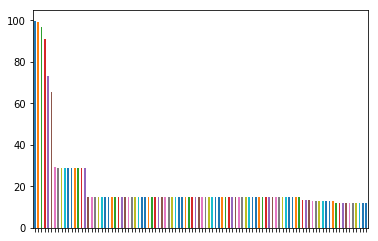

In [124]:
# Before calling MissingValuesToNan

_ = PlotIsNullDist(azdias)

ALTER_KIND4                    99.864792
TITEL_KZ                       99.757636
ALTER_KIND3                    99.307691
ALTER_KIND2                    96.690047
ALTER_KIND1                    90.904837
AGER_TYP                       76.019640
EXTSEL992                      73.399639
KK_KUNDENTYP                   65.596749
KBA05_BAUMAX                   53.468668
D19_LETZTER_KAUF_BRANCHE       50.767543
ALTER_HH                       34.813699
ALTERSKATEGORIE_FEIN           29.504130
D19_KONSUMTYP                  28.849522
D19_LOTTO                      28.849522
D19_BANKEN_ONLINE_QUOTE_12     28.849522
D19_GESAMT_ONLINE_QUOTE_12     28.849522
D19_TELKO_ONLINE_QUOTE_12      28.849522
D19_VERSAND_ONLINE_QUOTE_12    28.849522
D19_SOZIALES                   28.849522
D19_VERSI_ONLINE_QUOTE_12      28.849522
dtype: float64


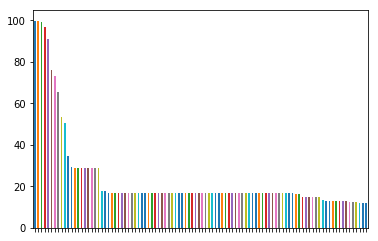

In [125]:
# After calling MissingValuesToNan

azMissToNan = PlotIsNullDist(azTmpCleaned)

### Outliner exclusion by nan values

As expected, the number of missing values grew. Following columns keep more than 30% missing values after encoding: AGER_TYP, D19_LETZTER_KAUF_BRANCHE, KBA05_BAUMAX, KK_KUNDENTYP. I will drop all columns with % missing values > 40%.

In [126]:
for dropCol in list(dsh.GetColumnHavingNanPercent(
    azTmpCleaned, percent = 0.4).columns):
    print('Adding column: ', dropCol)
    CleanConfig.ColumnsToDrop.append(dropCol)

Adding column:  AGER_TYP
Adding column:  ALTER_KIND1
Adding column:  ALTER_KIND2
Adding column:  ALTER_KIND3
Adding column:  ALTER_KIND4
Adding column:  D19_LETZTER_KAUF_BRANCHE
Adding column:  EXTSEL992
Adding column:  KBA05_BAUMAX
Adding column:  KK_KUNDENTYP
Adding column:  TITEL_KZ


The following functions will help me to identify and remove outliner rows and columns.

In [127]:
def CalcMeanOutlinerRows(dfInput):
    '''
    Calc mean of missing values in each row
    '''
    return dfInput.isnull().sum(axis = 1) / dfInput.shape[1]

In [128]:
dfsum = CalcMeanOutlinerRows(azTmpCleaned)

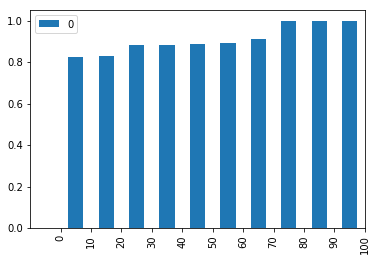

In [129]:
tmp = []
for ind in range(11):
    #print(dfsum[dfsum.between(0.0, ind / 10)].shape)
    tmp.append(dfsum[dfsum.between(0.0, ind / 11)].shape[0] / dfsum.shape[0])

tmp = pd.DataFrame(tmp)
ax = tmp.plot(kind = 'bar')
ax.set_xticks([x + 0.5 for x in range(0, 11)])
_ = ax.set_xticklabels([str(x) for x in range(0, 110, 10)])

In [130]:
print(dfsum.shape[0])
for ind in range(1, 11):
    print(ind * 10, '%: ', dfsum.shape[0] - dfsum[dfsum <= ind / 10].shape[0], (dfsum.shape[0] - dfsum[dfsum <= ind / 10].shape[0]) / dfsum.shape[0])

891221
10 %:  154644 0.17351925055625933
20 %:  132532 0.14870834506817052
30 %:  105811 0.11872588280572384
40 %:  100295 0.11253662110744697
50 %:  99969 0.11217083080403177
60 %:  93176 0.10454870340802114
70 %:  73517 0.0824902016447099
80 %:  0 0.0
90 %:  0 0.0
100 %:  0 0.0


In [131]:
ind = 2.5
print(ind * 10, '%: ', dfsum.shape[0] - dfsum[dfsum <= ind / 10].shape[0], (dfsum.shape[0] - dfsum[dfsum <= ind / 10].shape[0]) / dfsum.shape[0])

25.0 %:  106459 0.11945297518797246


I decide to keep rows having missing values <= 25%. 106459 rows would be dropped (circa 12% of all rows) because I don't see any advantage of considering rows with more missing values. Considering 2% more rows (18823) with up to 40% is missing values is in my eyes not useful.

In [132]:
CleanConfig.RowsToTropByMisNan = 0.25

In [133]:
def RemoveOutlinerRows(dfInput):
    '''
    Remove rows by: CalcMeanOutlinerRows(dfInput) <= CleanConfig.RowsToTropByMisNan 
    '''
    dfnew = dfInput[CalcMeanOutlinerRows(dfInput) <= CleanConfig.RowsToTropByMisNan]
    dsh.PrintLine('{} rows removed having more than {}% of missing values'.format(dfInput.shape[0] - dfnew.shape[0], CleanConfig.RowsToTropByMisNan))
    return dfnew

def SelectOutlinerRows(dfInput):
    '''
    Select rows by: dfInput[CalcMeanOutlinerRows(dfInput) > CleanConfig.RowsToTropByMisNan]
    '''
    return dfInput[CalcMeanOutlinerRows(dfInput) > CleanConfig.RowsToTropByMisNan]

In [134]:
azdiasConsid = RemoveOutlinerRows(azdias)

azdiasOut = SelectOutlinerRows(azdias)

-------------------- 106028 rows removed having more than 0.25% of missing values --------------------


In [135]:
azdias.shape, azdiasOut.shape, azdiasConsid.shape

((891221, 366), (106028, 366), (785193, 366))

In [136]:
def PlotSubSet(df1, df2, ind):
    title = 'Distribution for the column: ' + df1.columns[ind]
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    sns.countplot(df1.iloc[:, ind].values, color = 'blue')
    plt.subplot(1, 2, 2)
    sns.countplot(df2.iloc[:, ind].values, color = 'blue')

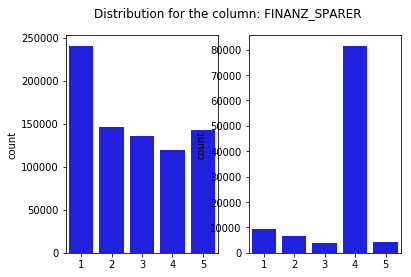

In [137]:
inspecColumns = ['FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER', 'HH_EINKOMMEN_SCORE', 'KONSUMNAEHE', 'KBA13_ANZAHL_PKW', 'KKK']

pltConsid = azdiasConsid[inspecColumns]
pltOut = azdiasOut[inspecColumns]
    
PlotSubSet(pltConsid, pltOut, 0)

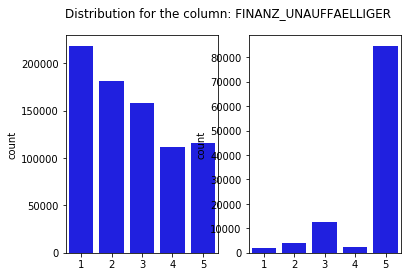

In [138]:
PlotSubSet(pltConsid, pltOut, 1)

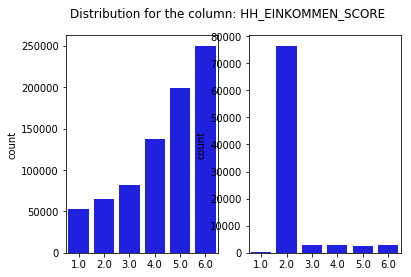

In [139]:
PlotSubSet(pltConsid, pltOut, 2)

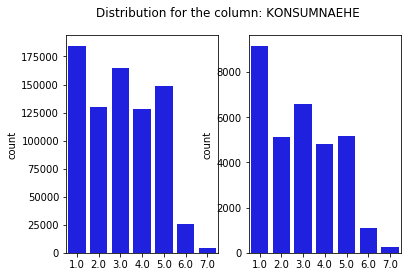

In [140]:
PlotSubSet(pltConsid, pltOut, 3)

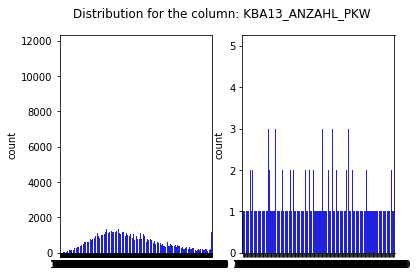

In [141]:
PlotSubSet(pltConsid, pltOut, 4)

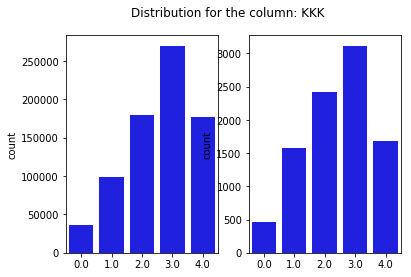

In [142]:
PlotSubSet(pltConsid, pltOut, 5)

In [143]:
del azdiasConsid, azdiasOut # release some memory

I decided to compare the columns because they are widelsy spread with the prob of missing values. Furthermore, I guess these columns are relevant. For example Finanz_Sparer says if a person is a money saver or not, HH_Einkomen_Sore and KBA13_Anzahl_PKW the netto income per household, distance from points of sale (personally I would take people - who live far away - more into consideration) and their mobility, and finally KKK the purchasing power in the relevant region.

The plots for...:

Finanz_Sparer and HH_EINKOMMEN_SCOREcompletely differ,
KONSUMNAEHE are almost equal for value 1, 2, 3, 4, 6, 7, value 5 is in subplot 1 higher,
KBA13_ANZAHL_PKW are also different,
and KKK are for value 3 and 4 is almost equal. Subset2 has more infos with value 2, subset1 has less infos with value 1,
I added the feature Finanz_Unauffaelliger because I was irritated because of the equality of some plots. And this output is completely different. I guess the plot for columns with high range of missing values is likely to be equal.

Now the next step is to re-encode features, especially the categorical ones.

### Convert, order, summarize, exclude, extend and encode features

#### Convert

In [144]:
azTmpCleaned[[x for x in azdias.columns 
        if (azTmpCleaned[x].dtype == object or 'CAMEO' in x)
       and x not in CleanConfig.ColumnsToDrop
       ]].head(8)

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,OST_WEST_KZ
0,NaN,NaN,NaN,None
1,8A,8.0,51.0,W
2,4C,4.0,24.0,W
3,2A,2.0,12.0,W
4,6B,6.0,43.0,W
5,8C,8.0,54.0,W
6,4A,4.0,22.0,W
7,2D,2.0,14.0,W


CAMEO_DEUG_2015 classifies people into 1 - upper class and 10 - urban worker class.

A discussion about CAMEO_INTL_2015 is below.

In [167]:
def ColumnsToFloat( inpDf, trimIntl = True ):
    CleanConfig.ColumnsTypeToFloat = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
    
    dsh.PrintLine('Converting columns to float: {}'.format(CleanConfig.ColumnsTypeToFloat))
    df = inpDf.copy(deep = True)
           
    allsucc = True
    for col in CleanConfig.ColumnsTypeToFloat:
        
        try:
            df[col] = df[col].astype(np.float64)
            if df[col].dtype in dsh.NumberTypes:
                CleanConfig.ColumnValues[col].DType = df[col].dtype
                continue
            print('Type of column "{}" did not change...'.format(col))
            allsucc = False
        except:
            print('Error converting column "{}" to float'.format(col))
            allsucc = False
    if allsucc:
        dsh.PrintLine('Types successfully converted')
    else:
        dsh.PrintLine('Finished converting types with errors')
    return df

In [168]:
azCleaned2 = ColumnsToFloat(MissingValuesToNan(azdias))

-------------------- Start converting missing values to nan --------------------
ALTER_HH - ['0', 0, '0.0'] - 236768 - 0
CAMEO_DEUG_2015 - ['-1', -1, '-1.0', 'X'] - 373 - 0
HEALTH_TYP - ['-1', -1, '-1.0'] - 111196 - 0
KBA05_ALTER1 - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_ALTER2 - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_ALTER3 - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_ALTER4 - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_ANHANG - ['-1', -1.0, '9', 9.0] - 13877 - 0
KBA05_AUTOQUOT - ['-1', -1.0, '9', 9.0] - 14791 - 0
KBA05_CCM1 - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_CCM2 - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_CCM3 - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_CCM4 - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_DIESEL - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_FRAU - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_HERST1 - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_HERST2 - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_HERST3 - ['-1', -1.0, '9', 9.0] - 14786 - 0
KBA05_HERST4 - ['-1', -1.0, '9', 9.0] - 

#### Summarize, exclude features

As there are still many columns and new columns will be adde due to one-hot encoding, I summarize/simplify the data as follows:

In [147]:
dftmp = dsh.SelectColumnsByWildcard(azdias, '*kba13*')
# dftmp = dftmp[dftmp['D19_TELKO_ANZ_12'] > 5]
print(list(dftmp.head().columns))

-------------------- Start finding and keeping columns matchting to wildcards: ['*kba13*'] --------------------
-------------------- Finished keeping columns matchting to wildcards: 116 --------------------
['KBA13_ALTERHALTER_30', 'KBA13_ALTERHALTER_45', 'KBA13_ALTERHALTER_60', 'KBA13_ALTERHALTER_61', 'KBA13_ANTG1', 'KBA13_ANTG2', 'KBA13_ANTG3', 'KBA13_ANTG4', 'KBA13_ANZAHL_PKW', 'KBA13_AUDI', 'KBA13_AUTOQUOTE', 'KBA13_BAUMAX', 'KBA13_BJ_1999', 'KBA13_BJ_2000', 'KBA13_BJ_2004', 'KBA13_BJ_2006', 'KBA13_BJ_2008', 'KBA13_BJ_2009', 'KBA13_BMW', 'KBA13_CCM_0_1400', 'KBA13_CCM_1000', 'KBA13_CCM_1200', 'KBA13_CCM_1400', 'KBA13_CCM_1401_2500', 'KBA13_CCM_1500', 'KBA13_CCM_1600', 'KBA13_CCM_1800', 'KBA13_CCM_2000', 'KBA13_CCM_2500', 'KBA13_CCM_2501', 'KBA13_CCM_3000', 'KBA13_CCM_3001', 'KBA13_FAB_ASIEN', 'KBA13_FAB_SONSTIGE', 'KBA13_FIAT', 'KBA13_FORD', 'KBA13_GBZ', 'KBA13_HALTER_20', 'KBA13_HALTER_25', 'KBA13_HALTER_30', 'KBA13_HALTER_35', 'KBA13_HALTER_40', 'KBA13_HALTER_45', 'KBA13_HALTER_5

In [148]:
azdias[['KBA13_CCM_1000', 'KBA13_CCM_1200', 'KBA13_CCM_1400', 'KBA13_CCM_0_1400']][10:20]

,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_0_1400
10,3.0,5.0,3.0,5.0
11,NaN,NaN,NaN,NaN
12,3.0,2.0,2.0,2.0
13,3.0,0.0,3.0,3.0
14,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN
16,3.0,3.0,3.0,3.0
17,NaN,NaN,NaN,NaN
18,2.0,3.0,3.0,3.0
19,1.0,0.0,2.0,2.0


I will drop following colums because they are described by KBA13_CCM_0_1400, 1400_2500, 2501.

In [149]:
CleanConfig.ColumnsToDrop.extend([
    'KBA13_CCM_1000',
    'KBA13_CCM_1200',
    'KBA13_CCM_1400',
    'KBA13_CCM_1500',
    'KBA13_CCM_1600',
    'KBA13_CCM_1800',
    'KBA13_CCM_2000',
    'KBA13_CCM_2500'])

In [150]:
azdias[['KBA13_BJ_1999', 'KBA13_BJ_2000', 'KBA13_BJ_2004']][10:20]

,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004
10,3.0,4.0,3.0
11,NaN,NaN,NaN
12,3.0,3.0,2.0
13,3.0,4.0,3.0
14,NaN,NaN,NaN
15,NaN,NaN,NaN
16,3.0,3.0,3.0
17,NaN,NaN,NaN
18,2.0,1.0,3.0
19,2.0,2.0,3.0


BJ_2004 means share of card built BEFORE 2004, BJ_1999, 2000 stands for cars built betwen 1995-1999, 2000-2003.
I drop BJ_1999, 2000 and summarize the values of columns BJ_2006-2009 in a new column called KBA13_BJ_2004_O.

In [151]:
CleanConfig.ColumnsToDrop.append('KBA13_BJ_1999')
CleanConfig.ColumnsToDrop.append('KBA13_BJ_2000')

And the same for KBA13_ALTERHALTER and KBA13_Halter. KBA13_HALTER is described by KBA13_ALTERHALTER.

In [152]:
CleanConfig.ColumnsToDrop.extend(dsh.GetMatches(azdias.columns, '*_halter_*'))

Dito for KMH_110, 140, 180, 250 and KW_30, 40, ..., 

In [153]:
CleanConfig.ColumnsToDrop.extend([
    'KBA13_KMH_110',
    'KBA13_KMH_140',
    'KBA13_KMH_180',
    'KBA13_KMH_250',
    'KBA13_KMH_251',

    'KBA13_KW_30',
    'KBA13_KW_40',
    'KBA13_KW_50',
    'KBA13_KW_60',
    'KBA13_KW_70',
    'KBA13_KW_80',
    'KBA13_KW_90',
    'KBA13_KW_110',
    'KBA13_KW_120',

])


In [154]:
CleanConfig.ColumnsSummarize = {
    'KBA13_BJ_2004_O' : [
        'KBA13_BJ_2006',
        'KBA13_BJ_2008',
        'KBA13_BJ_2009'],
    
    
    'KBA13_ALTERHALTER_U45' : [
        'KBA13_ALTERHALTER_30', 
        'KBA13_ALTERHALTER_45'],
    
    'KBA13_ALTERHALTER_O45' : [
        'KBA13_ALTERHALTER_60', 
        'KBA13_ALTERHALTER_61'],
    
    
    'KBA05_CCM_U1800' : [
        'KBA05_CCM1', 
        'KBA05_CCM2'],
    
    'KBA05_CCM_O1800' : [
        'KBA05_CCM3', 
        'KBA05_CCM4'],
    
    'KBA05_ANTG12' : [
        'KBA05_ANTG1', 
        'KBA05_ANTG2'],
    
    'KBA05_ANTG34' : [
        'KBA05_ANTG3', 
        'KBA05_ANTG4'],
    
    
    'KBA05_ZUL12' : [
        'KBA05_ZUL1', 
        'KBA05_ZUL2'],
    
    'KBA05_ZUL12' : [
        'KBA05_ZUL1', 
        'KBA05_ZUL2'],
    
    'KBA05_SEG1234' : [
        'KBA05_SEG1', 
        'KBA05_SEG2', 
        'KBA05_SEG3', 
        'KBA05_SEG4'],
    
    'KBA05_SEG567' : [
        'KBA05_SEG5', 
        'KBA05_SEG6', 
        'KBA05_SEG7'],
    
    'KBA05_SEG8910' : [
        'KBA05_SEG8', 
        'KBA05_SEG9', 
        'KBA05_SEG10'],
    
    
    'KBA05_ZUL12' : [
        'KBA05_ZUL1', 
        'KBA05_ZUL2'],
    
    'KBA05_ZUL34' : [
        'KBA05_ZUL3', 
        'KBA05_ZUL4'],
    
    'KBA05_HERST_GER' : [
        'KBA05_HERST1', 
        'KBA05_HERST2'],
    
    'KBA05_HERST_NOTGER' : [
        'KBA05_HERST3', 
        'KBA05_HERST4', 
        'KBA05_HERST5'],
    
    'KBA05_KRSHERST123' : [
        'KBA05_KRSHERST1', 
        'KBA05_KRSHERST2', 
        'KBA05_KRSHERST3'],

    
    'PLZ8_ANTG12' : [
        'PLZ8_ANTG1', 
        'PLZ8_ANTG2'],
    
    'PLZ8_ANTG34' : [
        'PLZ8_ANTG3', 
        'PLZ8_ANTG4'],
}



In [155]:
def SummarizeColumns(dfImput):
    dsh.PrintLine('Start summarizing columns')
    df = dfImput.copy(deep = True)
    
    for newcol, oldcols in CleanConfig.ColumnsSummarize.items():
        print('Summing into "{}": '.format(newcol), oldcols)
        shpbefore = df.shape[1]
        df[newcol] = np.divide(df[oldcols].sum(axis = 1), len(oldcols))
        df = df[[col for col in df.columns if col not in oldcols]]
        print('Number of columns: {} -> {}'.format(shpbefore, df.shape[1]))
    dsh.PrintLine('Finished summarizing columns')
    return df

In [156]:
CleanConfig.ColumnValues['PRAEGENDE_JUGENDJAHRE'].Meanings

['unknown',
 '40ies - war years (Mainstream, O+W)',
 '40ies - reconstruction years (Avantgarde, O+W)',
 '50ies - economic miracle (Mainstream, O+W)',
 '50ies - milk bar / Individualisation (Avantgarde, O+W)',
 '60ies - economic miracle (Mainstream, O+W)',
 '60ies - generation 68 / student protestors (Avantgarde, W)',
 '60ies - opponents to the building of the Wall (Avantgarde, O)',
 '70ies - family orientation (Mainstream, O+W)',
 '70ies - peace movement (Avantgarde, O+W)',
 '80ies - Generation Golf (Mainstream, W)',
 '80ies - ecological awareness (Avantgarde, W)',
 '80ies - FDJ / communist party youth organisation (Mainstream, O)',
 '80ies - Swords into ploughshares (Avantgarde, O)',
 '90ies - digital media kids (Mainstream, O+W)',
 '90ies - ecological awareness (Avantgarde, O+W)']

The last AZDIAS project provided the Data_Dictioanry.md file with information about the column 'CAMEO_INTL_2015'. So I will use this to encode my

#### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

This column additionally contains information about Mainstream/Avantgarde and the ages. I extract these features.

In [157]:
def ExtractNewFeatures(dfinp):
    '''
    Add following columns to dataframe:
    MainAvant: 1 if is mainstream, 0 if avant
    
    '''
    dsh.PrintLine('Start extracting features')
    df = dfinp.copy(deep = True)
    mainstreamId = []
    avantId = []
    ages = {}
    for ind, x in enumerate(CleanConfig.ColumnValues['PRAEGENDE_JUGENDJAHRE'].Meanings):
        if ind == 0:
            continue
        if 'Mainstream' in x:
            mainstreamId.append(ind)
        else:
            avantId.append(ind)
        
        ages[ind] = float(x[:2]) / 10.0
        
    df['PRAEGENDE_JUGENDJAHRE_MainAvant'] = df['PRAEGENDE_JUGENDJAHRE'].apply(
        lambda x: 1 if x in mainstreamId
                else 0 if x in avantId
                else x
    )
    
    df['PRAEGENDE_JUGENDJAHRE_Ages'] = df['PRAEGENDE_JUGENDJAHRE'].apply(
        lambda x: ages[x] if x in ages.keys() else x
    )
    
    df = df.drop('PRAEGENDE_JUGENDJAHRE', axis = 1)
    
    df['CAMEO_INTL_2015_Wealth'] = df['CAMEO_INTL_2015'].apply(
        lambda x: x if np.isnan(x) else x / 10
    )
    df['CAMEO_INTL_2015_Ages'] = df['CAMEO_INTL_2015'].apply(
        lambda x: x if np.isnan(x) else (x - 10*int(x/10))
    )
    
    df = df.drop('CAMEO_INTL_2015', axis = 1)
    
    dsh.PrintLine('Finished extracting features')
    return df

#### Order

There are some columns whose values to not correspond for what they actually stand for (for example (0 - verly likely, 10 very unlikely). I intend to run PCA on the data and for easier interpretation I change the order of these values.

In [158]:
CleanConfig.ColumnsReorderValues = []
for cv in CleanConfig.ColumnValues.values():
    if cv.LowestValue is not None and cv.LowestValue > 1:
        print(cv.ColumnName, cv.LowestValue)
        CleanConfig.ColumnsReorderValues.append(cv.ColumnName)

CAMEO_DEUG_2015 6.0
D19_BANKEN_OFFLINE_DATUM 10.0
D19_BANKEN_ONLINE_DATUM 10.0
D19_GESAMT_DATUM 10.0
D19_GESAMT_OFFLINE_DATUM 10.0
D19_GESAMT_ONLINE_DATUM 10.0
D19_TELKO_OFFLINE_DATUM 10.0
D19_VERSAND_DATUM 10.0
D19_VERSAND_OFFLINE_DATUM 10.0
D19_VERSAND_ONLINE_DATUM 10.0
FINANZ_ANLEGER 4.0
FINANZ_HAUSBAUER 4.0
FINANZ_MINIMALIST 4.0
FINANZ_SPARER 4.0
FINANZ_UNAUFFAELLIGER 4.0
FINANZ_VORSORGER 4.0
GEBAEUDETYP_RASTER 4.0
HH_EINKOMMEN_SCORE 5.0
KBA05_HERSTTEMP 3.0
KBA05_MAXSEG 2.0
KBA05_MODTEMP 3.0
KKK 4.0
MOBI_REGIO 4.0
REGIOTYP 5.0
RETOURTYP_BK_S 2.0
SEMIO_DOM 5.0
SEMIO_ERL 5.0
SEMIO_FAM 5.0
SEMIO_KAEM 5.0
SEMIO_KRIT 5.0
SEMIO_KULT 5.0
SEMIO_LUST 5.0
SEMIO_MAT 5.0
SEMIO_PFLICHT 5.0
SEMIO_RAT 5.0
SEMIO_REL 5.0
SEMIO_SOZ 5.0
SEMIO_TRADV 5.0
SEMIO_VERT 5.0


In [159]:
def ReorderValues(dfInput):
    dsh.PrintLine('Start reordering values')
    df = dfInput.copy(deep = True)
    
    for col in CleanConfig.ColumnsReorderValues:
        vmin = df[col].min()
        vmax = df[col].max()

        repDic = {}
        for ind in range (int(vmin), int(vmax) + 1):
            repDic[ind] = vmax + 1 - ind

        print('Applying reorder on {}: '.format(col), repDic)
        try:
            df[col] = df[col].apply(lambda x: repDic[x] if x in repDic.keys() else x)
        except:
            print('Error reordering values in column "{}": '.format(col), repDic, df[col].unique())
            return
    
    dsh.PrintLine('Finished reordering values')
    return df

In [160]:
azReordered = ReorderValues(azCleaned2)

-------------------- Start reordering values --------------------
Applying reorder on CAMEO_DEUG_2015:  {1: 9.0, 2: 8.0, 3: 7.0, 4: 6.0, 5: 5.0, 6: 4.0, 7: 3.0, 8: 2.0, 9: 1.0}
Applying reorder on D19_BANKEN_OFFLINE_DATUM:  {1: 10, 2: 9, 3: 8, 4: 7, 5: 6, 6: 5, 7: 4, 8: 3, 9: 2, 10: 1}
Applying reorder on D19_BANKEN_ONLINE_DATUM:  {1: 10, 2: 9, 3: 8, 4: 7, 5: 6, 6: 5, 7: 4, 8: 3, 9: 2, 10: 1}
Applying reorder on D19_GESAMT_DATUM:  {1: 10, 2: 9, 3: 8, 4: 7, 5: 6, 6: 5, 7: 4, 8: 3, 9: 2, 10: 1}
Applying reorder on D19_GESAMT_OFFLINE_DATUM:  {1: 10, 2: 9, 3: 8, 4: 7, 5: 6, 6: 5, 7: 4, 8: 3, 9: 2, 10: 1}
Applying reorder on D19_GESAMT_ONLINE_DATUM:  {1: 10, 2: 9, 3: 8, 4: 7, 5: 6, 6: 5, 7: 4, 8: 3, 9: 2, 10: 1}
Applying reorder on D19_TELKO_OFFLINE_DATUM:  {1: 10, 2: 9, 3: 8, 4: 7, 5: 6, 6: 5, 7: 4, 8: 3, 9: 2, 10: 1}
Applying reorder on D19_VERSAND_DATUM:  {1: 10, 2: 9, 3: 8, 4: 7, 5: 6, 6: 5, 7: 4, 8: 3, 9: 2, 10: 1}
Applying reorder on D19_VERSAND_OFFLINE_DATUM:  {1: 10, 2: 9, 3: 8, 4: 

In [161]:
pd.concat([
    azdias[azdias.index == 1][CleanConfig.ColumnsReorderValues], 
    azReordered[azReordered.index == 1][CleanConfig.ColumnsReorderValues]
])

,CAMEO_DEUG_2015,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_TELKO_OFFLINE_DATUM,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,...,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT
1,8.0,10,10,10,10,10,10,10,10,10,...,4,3,2,3,7,6,4,5,6,1
1,2,1,1,1,1,1,1,1,1,1,...,4,5,6,5,1,2,4,3,2,7


#### Encoding

In [163]:
[x for x in azdias.columns if (azdias[x].dtype == object
and x not in CleanConfig.ColumnsToDrop)
]

['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'OST_WEST_KZ']

In [177]:
CleanConfig.ColumnsBinaryEncode = [
    'OST_WEST_KZ'                                  
]

CleanConfig.ColumnsOneHotEncode = [
    
    'CAMEO_DEU_2015'
]

In [178]:
def EncodeColumns(dfInput):
    dsh.PrintLine('Start one-hot encoding')
    df = dfInput.copy(deep = True)
    
    dirColReplacements = {}
    
    for col in CleanConfig.ColumnsBinaryEncode:
        try:
            df[col] = dsh.ApplyBinaryEncoding(df[col])
        except:
            print('Error during binary encoding column: ', col)
    
    for col in CleanConfig.ColumnsOneHotEncode:
        colval = CleanConfig.ColumnValues[col]
        print('One-hot encode column: ', col)
        df, _ = dsh.ApplyOneHotEncoding(df, columns = [col])
    
    dsh.PrintLine('Finished one-hot encoding')
    return df

In [179]:
def CleanData(inpDf):
    dsh.PrintLine('Start cleaning dataframe sized: {}'.format(inpDf.shape))
    
    df = inpDf.copy(deep = True)
    
    # remove columns we don't want
    df = RemoveColumns(df)
    
    # convert missing values to nan
    df = MissingValuesToNan(df)
    
    # convert categorical to numerical
    df = ColumnsToFloat(df)
    
    # drop rows by % of missing values
    df = RemoveOutlinerRows(df)
    
    # extract new features and drop old columns
    df = ExtractNewFeatures(df)
    
    # reorder values (so that 0 means low and x > 0 for high)
    df = ReorderValues(df)
    
    # reduce columns
    df = SummarizeColumns(df)
    
    # apply onehot encoding on categorical
    df = EncodeColumns(df)
    
    return df

In [182]:
azdiasCleaned = CleanData(azdias)

-------------------- Start cleaning dataframe sized: (891221, 366) --------------------
-------------------- Start finding and removing columns matchting to wildcards: ['EINGEFUEGT_AM', 'LNR', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'D19_LETZTER_KAUF_BRANCHE', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ', 'KBA13_CCM_1000', 'KBA13_CCM_1200', 'KBA13_CCM_1400', 'KBA13_CCM_1500', 'KBA13_CCM_1600', 'KBA13_CCM_1800', 'KBA13_CCM_2000', 'KBA13_CCM_2500', 'KBA13_BJ_1999', 'KBA13_BJ_2000', 'KBA13_HALTER_20', 'KBA13_HALTER_25', 'KBA13_HALTER_30', 'KBA13_HALTER_35', 'KBA13_HALTER_40', 'KBA13_HALTER_45', 'KBA13_HALTER_50', 'KBA13_HALTER_55', 'KBA13_HALTER_60', 'KBA13_HALTER_65', 'KBA13_HALTER_66', 'KBA13_KMH_110', 'KBA13_KMH_140', 'KBA13_KMH_180', 'KBA13_KMH_250', 'KBA13_KMH_251', 'KBA13_KW_30', 'KBA13_KW_40', 'KBA13_KW_50', 'KBA13_KW_60', 'KBA13_KW_70', 'KBA

Applying reorder on SEMIO_REL:  {1: 7, 2: 6, 3: 5, 4: 4, 5: 3, 6: 2, 7: 1}
Applying reorder on SEMIO_SOZ:  {1: 7, 2: 6, 3: 5, 4: 4, 5: 3, 6: 2, 7: 1}
Applying reorder on SEMIO_TRADV:  {1: 7, 2: 6, 3: 5, 4: 4, 5: 3, 6: 2, 7: 1}
Applying reorder on SEMIO_VERT:  {1: 7, 2: 6, 3: 5, 4: 4, 5: 3, 6: 2, 7: 1}
-------------------- Finished reordering values --------------------
-------------------- Start summarizing columns --------------------
Summing into "KBA13_BJ_2004_O":  ['KBA13_BJ_2006', 'KBA13_BJ_2008', 'KBA13_BJ_2009']
Number of columns: 314 -> 312
Summing into "KBA13_ALTERHALTER_U45":  ['KBA13_ALTERHALTER_30', 'KBA13_ALTERHALTER_45']
Number of columns: 312 -> 311
Summing into "KBA13_ALTERHALTER_O45":  ['KBA13_ALTERHALTER_60', 'KBA13_ALTERHALTER_61']
Number of columns: 311 -> 310
Summing into "KBA05_CCM_U1800":  ['KBA05_CCM1', 'KBA05_CCM2']
Number of columns: 310 -> 309
Summing into "KBA05_CCM_O1800":  ['KBA05_CCM3', 'KBA05_CCM4']
Number of columns: 309 -> 308
Summing into "KBA05_ANTG1

## Preparing for model - Feature transformation

In [183]:
oneHotCopy = azdiasCleaned.copy(deep = True)

In [184]:
imputer = preprocessing.Imputer(missing_values = 'NaN', strategy = 'median', axis = 0)

azImputed = pd.DataFrame(
    imputer.fit_transform(oneHotCopy), 
    columns = list(oneHotCopy.columns)
)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [45]:
azdiasTrain = pd.read_sql_table('azdiastrain', engine)

In [ ]:
customersTest = pd.read_sql_table('customerstest', engine)

In [54]:
[x for x in azdiasTrain.columns if x not in azdias.columns]

['RESPONSE']

In [55]:
[x for x in azdias.columns if x not in azdiasTrain.columns]

[]

In [53]:
azdiasTrain['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')